## Задача
Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.

# Работа с данными. Домашнее задание


### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Задание 1

Загрузите данные из файла `Mall_Customers.csv` в ноутбук и выведите первые пять строк на экран.

In [132]:
### YOUR CODE HERE ###
mall = pd.read_csv('Mall_Customers.csv')
mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39
1,2,Male,NaN,NaN,81
2,3,Female,NaN,16.0,6
3,4,Female,23.0,16.0,77
4,5,Female,31.0,17.0,40


### Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:
- количество пропусков в каждом признаке;
- распределения признаков;
- возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.

In [133]:
### YOUR CODE HERE ###
#посмотрим пропуски
mall.isnull().sum()

CustomerID                 0
Genre                     19
Age                       20
Annual Income (k$)        20
Spending Score (1-100)     0
dtype: int64

In [134]:
#Посмотрим количество полных дубликатов
mall.duplicated().sum()

0

In [135]:
#Посмотрим количество дубликатов по Id
mall['CustomerID'].duplicated().sum()
#удалим столбик Id, так как нет по нему повторений
mall.drop('CustomerID', axis=1, inplace=True)

In [136]:
#посмотрим распределение признаков
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genre                   181 non-null    object 
 1   Age                     180 non-null    float64
 2   Annual Income (k$)      180 non-null    float64
 3   Spending Score (1-100)  200 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.4+ KB


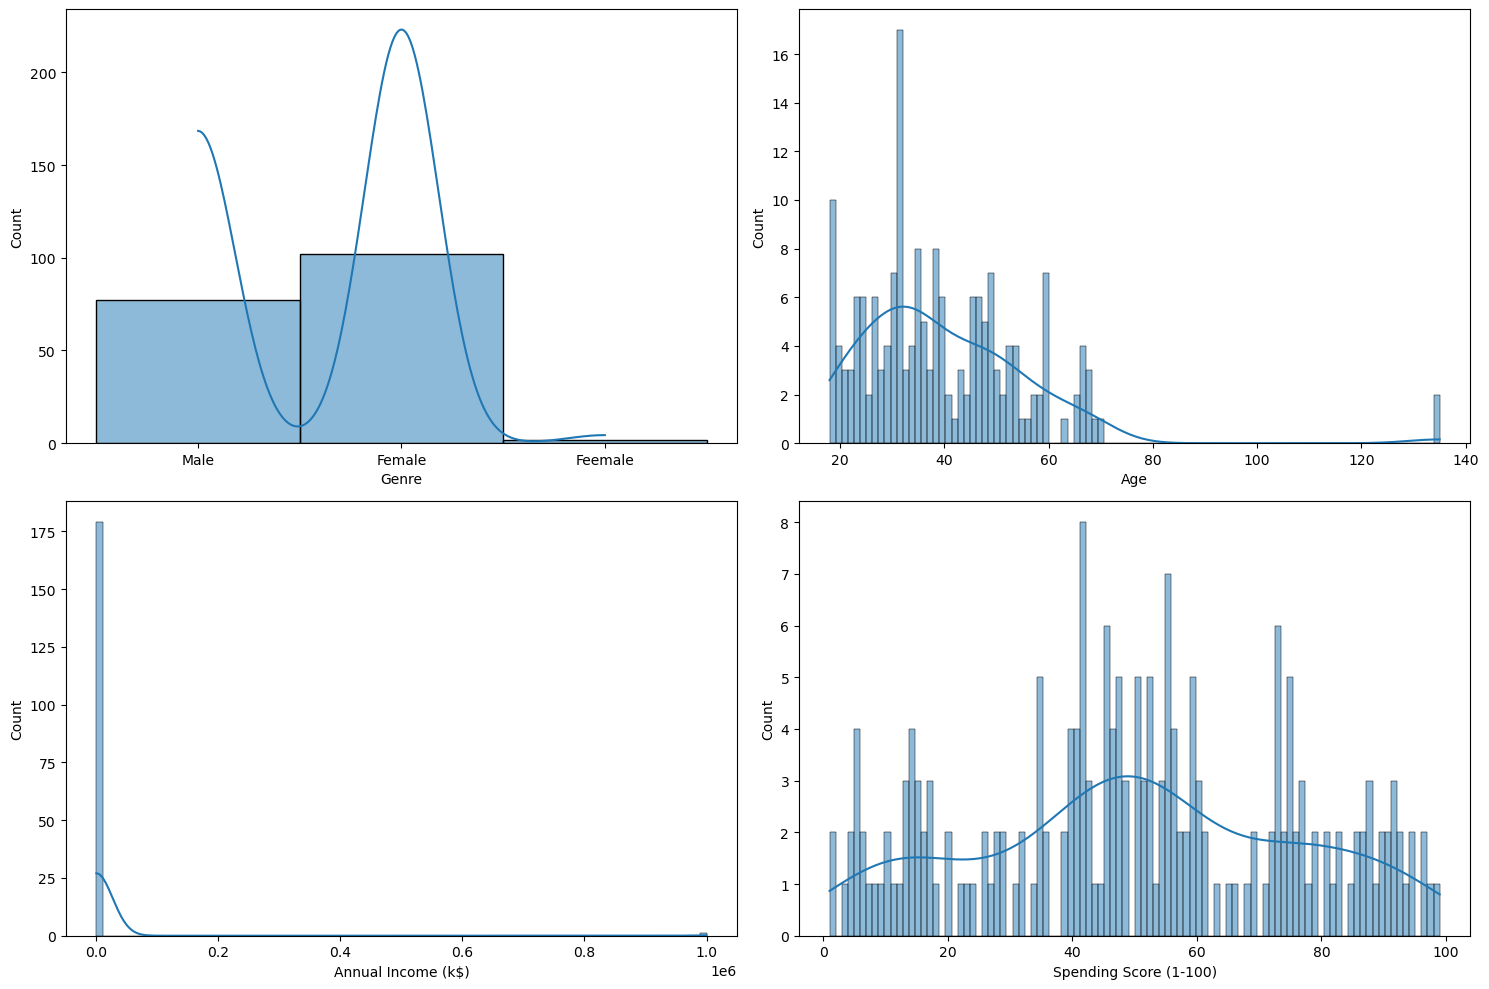

In [40]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(mall.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(mall[column], kde=True, bins=100)

plt.tight_layout()
plt.show()

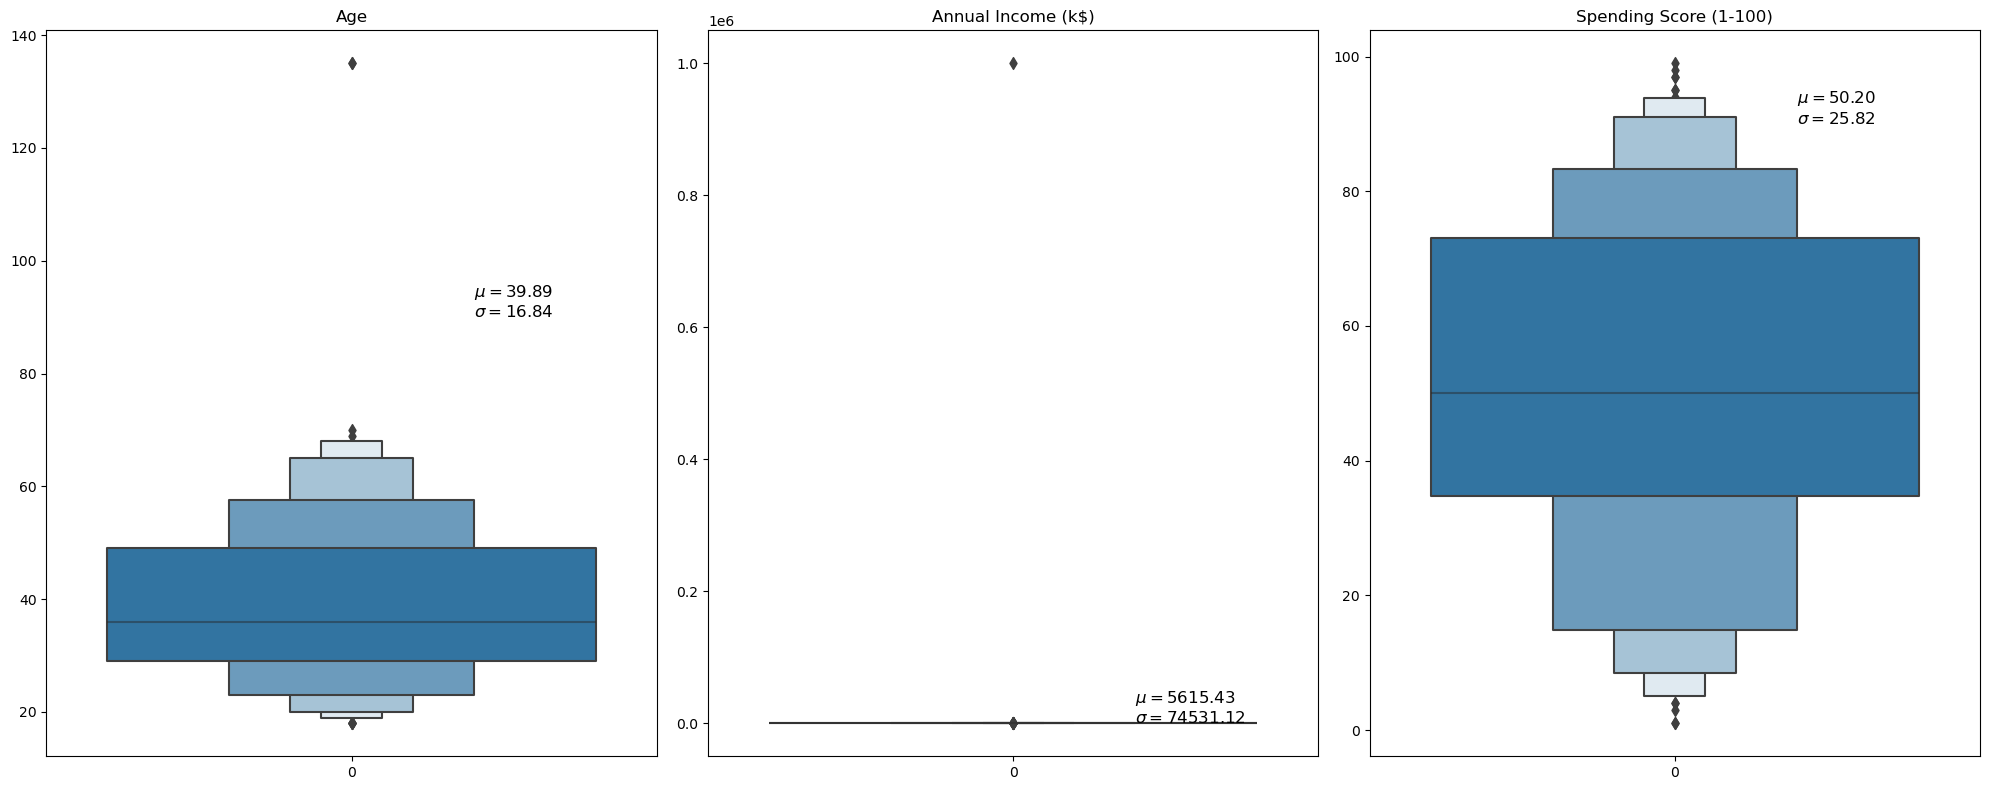

In [73]:
plt.figure(figsize=(20, 8))
for i, column in enumerate(mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], 1):
    plt.subplot(1, 3, i)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % mall[column].mean(),
        r'$\sigma=%.2f$' % mall[column].std()
    ))
    fig = sns.boxenplot(mall[column])
    fig.set_title(column)
    fig.text(0.2, 90, textstr, fontsize=12)
plt.tight_layout()
plt.show()

По графикам можно заключить, что:
В признаке Gender есть три значения, третье значение - название второго, но с ошибкой, их нужно будет переимоновать во второе значение.
Признак Age имеет выбросы в районе 135 лет, их нужно будет удалить.
Признак Annual Income (k$) имеет скорее всего аномалию, что с ней делать?
Так же в данных есть неpначительное количество пропусков, их нужно будет заполнить.

In [137]:
mall.Genre[mall.Genre=='Feemale']='Female'
mall.Genre.value_counts()

Genre
Female    104
Male       77
Name: count, dtype: int64

### Задание 3

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.

In [278]:
### YOUR CODE HERE ###

from sklearn.model_selection import train_test_split
X=mall.drop('Spending Score (1-100)', axis=1)
y=mall['Spending Score (1-100)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Задание 4

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.

In [279]:
### YOUR CODE HERE ###
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Заполним пропуски в признаке Genre модой
X_train['Genre'] = X_train['Genre'].fillna(X_train['Genre'].mode()[0])

In [280]:
# Заполним пропуски в признаке Age медианным значением, так как мы пока не убрали выбросы.
imputer = SimpleImputer(strategy='median')
X_train['Age'] = imputer.fit_transform(X_train[['Age']])

In [281]:
# Заполним пропуски в признаке Annual Income (k$) по методу ближайших соседей.
imputer = KNNImputer(n_neighbors=5)
X_train['Annual Income (k$)'] = imputer.fit_transform(X_train[['Annual Income (k$)']])

In [282]:
#проверим пропуски
X_train.isna().sum()

Genre                 0
Age                   0
Annual Income (k$)    0
dtype: int64

### Задание 5

Найдите выбросы в признаках обучающей выборки. Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.


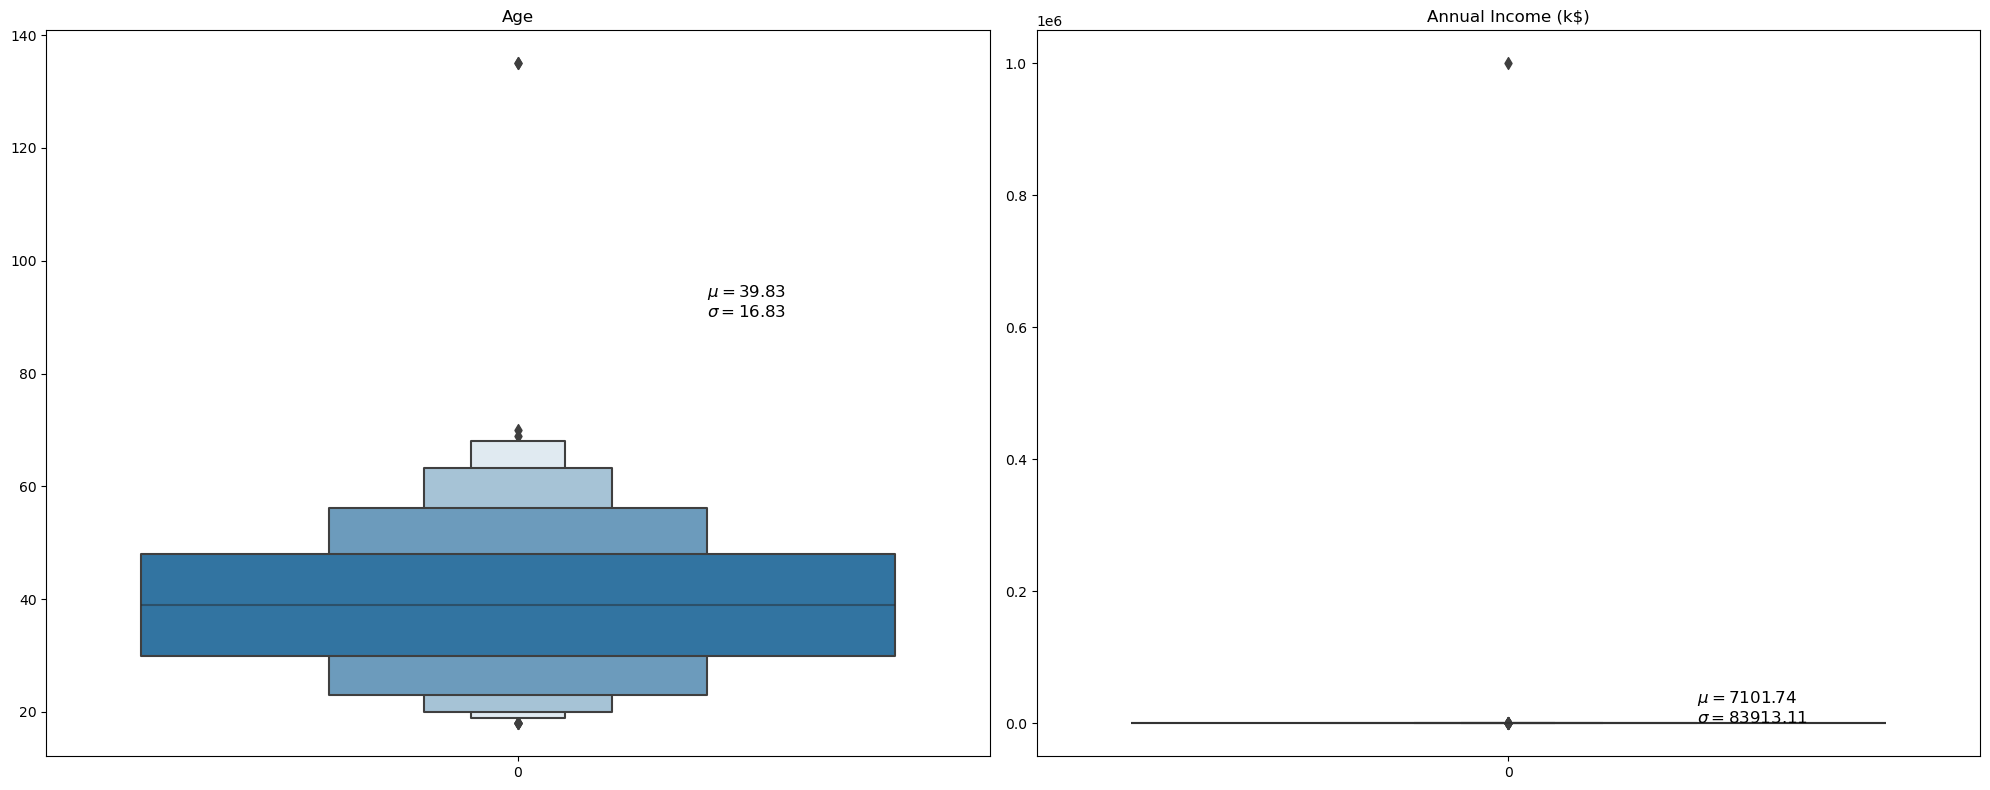

In [125]:
### YOUR CODE HERE ###
#Отрисуем бокс плоты, что бы понять куда попали выбросы
plt.figure(figsize=(20, 8))
for i, column in enumerate(X_train[['Age', 'Annual Income (k$)']], 1):
    plt.subplot(1, 2, i)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % X_train[column].mean(),
        r'$\sigma=%.2f$' % X_train[column].std()
    ))
    fig = sns.boxenplot(X_train[column])
    fig.set_title(column)
    fig.text(0.2, 90, textstr, fontsize=12)
plt.tight_layout()
plt.show()

In [283]:
#Если удалять выбросы в признаке Age при помощи кванитилей с обоих сторон, то мы потеряем и нижнюю границу по возрасту, так как отсекутся люди с нормальным возрастом.
#Поэтому просто удалим верхний выброс.
q_25=X_train.Age.quantile(0.25)
q_75=X_train.Age.quantile(0.75)
X_train=X_train[X_train.Age<q_75+(q_75-q_25)*1.5]

Высокое значение в Annual Income (k$) я считаю аномалией и пока не убираю. Так как всегже есть вероятность что в торговый центр за покупаками зайдет такой богатый человек.

### Задание 6

Нормализуйте численные признаки. Аргументируйте выбор стратегии нормализации для каждого признака.


In [284]:
### YOUR CODE HERE ###
#Для признака Age я возьму Min-Max Scaling, так как Min-Max Scaling позволяет масштабировать значения в диапазон [0, 1], сохраняя расстояния между возрастами.
#Для признака Annual Income (k$) я выберу StandardScaler, так как я оставляю в данных аномалию с очень высоким доходом. 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
X_train['Age'] = min_max_scaler.fit_transform(X_train[['Age']])
X_train['Annual Income (k$)'] = standard_scaler.fit_transform(X_train[['Annual Income (k$)']])

In [276]:
X_train.describe()

,Age,Annual Income (k$),Genre_le,Genre_en
count,140.000000,1.400000e+02,140.000000,140.000000
mean,0.185897,-4.758099e-17,0.400000,0.600000
std,0.149825,1.003591e+00,0.491657,0.491657
min,0.000000,-1.814916e+00,0.000000,0.000000
25%,0.102564,-6.692686e-01,0.000000,0.000000
50%,0.162393,8.767711e-02,0.000000,1.000000
75%,0.256410,7.218748e-01,1.000000,1.000000
max,1.000000,2.726758e+00,1.000000,1.000000


### Задание 7

Закодируйте категориальные признаки в обучающей выборке. Аргументируйте выбор способа кодирования.

In [285]:
### YOUR CODE HERE ###
#Буду использовать ручной аналог LabelEncoder, так как женщины покупают на 30% чаще мужчин, пусть женщины будут 1, и 1 лучше чем 0. 
counts = X_train['Genre'].value_counts()
X_train['Genre_en'] = X_train['Genre'].apply(lambda x: list(X_train['Genre'].value_counts().sort_values().index).index(x))
X_train.drop('Genre', axis=1, inplace=True)

In [316]:
X_train.head()

,Age,Annual Income (k$),Genre_en
108,0.961538,-0.089930,0
107,0.692308,-0.089930,0
189,0.346154,-0.089425,1
14,0.365385,-0.090472,0
56,0.634615,-0.090169,1


### Задание 8
Проведите очистку и подготовку тестовых данных. Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.

In [307]:
X_test.shape

(40, 3)

In [287]:
### YOUR CODE HERE ###
# Заполним пропуски в признаке Genre модой
X_test['Genre'] = X_test['Genre'].fillna(X_test['Genre'].mode()[0])


In [288]:
# Заполним пропуски в признаке Age медианным значением, так как мы пока не убрали выбросы.
imputer = SimpleImputer(strategy='median')
X_test['Age'] = imputer.fit_transform(X_test[['Age']])

In [290]:
# Заполним пропуски в признаке Annual Income (k$) по методу ближайших соседей.
imputer = KNNImputer(n_neighbors=5)
X_test['Annual Income (k$)'] = imputer.fit_transform(X_test[['Annual Income (k$)']])

In [301]:
X_test.isna().sum()

Genre                 0
Age                   0
Annual Income (k$)    0
dtype: int64

In [311]:
X_test.describe()

,Age,Annual Income (k$)
count,40.000000,40.000000
mean,39.650000,61.342105
std,12.189844,28.897943
min,21.000000,17.000000
25%,31.750000,38.750000
50%,36.000000,60.000000
75%,49.000000,85.500000
max,67.000000,137.000000


In [312]:
X_test

Genre                 0
Age                   0
Annual Income (k$)    0
dtype: int64

In [314]:
#Здесь выбросов нет.
counts = X_test['Genre'].value_counts()
X_test['Genre_en'] = X_test['Genre'].apply(lambda x: list(X_test['Genre'].value_counts().sort_values().index).index(x))
X_test.drop('Genre', axis=1, inplace=True)

In [315]:
X_test.head()

,Age,Annual Income (k$),Genre_en
58,27.0,46.0,1
40,65.0,38.0,1
34,49.0,33.0,1
102,67.0,62.0,0
184,41.0,99.0,1
